# Exponential Wave

A simple toy problem first [suggested](https://github.com/joshspeagle/dynesty/issues/111) by Johannes Buchner.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
np.random.seed(916301)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

We first generate a simple transformed periodic single from $0$ to $2\pi$ based on the relation:

$$ y(x) = \exp\left[ n_a \sin(f_a x + p_a) + n_b \sin(f_b x + p_b) \right] $$

This has six free parameters controling the relevant amplitude, period, and phase of each component. We also have a seventh, $\sigma$, corresponding to the amount of scatter.

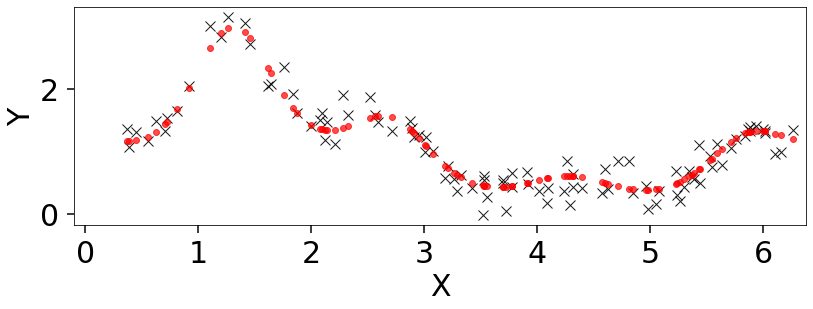

In [4]:
# x values sampled uniformly
x = np.random.uniform(0, 2 * np.pi, size=100)
x.sort()

# define model
fa = 4.2 / 4
fb = 42 / 10
na = 0.8
nb = 0.3
pa = 0.1
pb = 2.4
sigma = 0.2

# generate noisy observations
ypred = np.exp(na * np.sin(x * fa + pa) + nb * np.sin(x * fb + pb))
y = np.random.normal(ypred, sigma)

# plot results
plt.figure(figsize=(12, 5))
plt.plot(x, y, color='black', marker='x', 
         ls='none', alpha=0.9, markersize=10)
plt.plot(x, ypred, marker='o', color='red', ls='none', alpha=0.7)
plt.xlim([-0.1, 2 * np.pi + 0.1])
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()

Our priors will be uniform in all dimensions, with the phases having periodic boundary conditions.

In [5]:
def prior_transform(u):
    v = u * 100
    v[0] = u[0] * 4 - 2
    v[1] = u[1] * 4 - 2
    v[2] = (u[2] % 1.) * 2 * np.pi
    v[3] = u[3] * 4 - 2
    v[4] = u[4] * 4 - 2
    v[5] = (u[5] % 1.) * 2 * np.pi
    v[6] = u[6] * 2 - 2
    return v

def loglike(v):
    logna, logfa, pa, lognb, logfb, pb, logsigma = v
    na, fa, pa, nb, fb, pb, sigma = (10**logna, 10**logfa, pa, 
                                     10**lognb, 10**logfb, pb, 10**logsigma)
    ypred = np.exp(na * np.sin(x * fa + pa) + nb * np.sin(x * fb + pb))
    residsq = (ypred  - y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [6]:
# sample
sampler = dynesty.NestedSampler(loglike, prior_transform, 7, 
                                periodic=[2, 5],
                                sample='slice', nlive=250)
sampler.run_nested(dlogz=0.01)
res = sampler.results

8938it [10:56, 13.61it/s, +250 | bound: 214 | nc: 1 | ncall: 999726 | eff(%):  0.919 | loglstar:   -inf < 22.163 <    inf | logz: -8.909 +/-    nan | dlogz:  0.000 >  0.010]  


In [13]:
from dynesty import utils as dyfunc
from dynesty.results import Results

# compute ln(evidence) error
logzs = np.zeros((100, len(res.logvol)))
for i in range(100):
    res_s = dyfunc.simulate_run(res)
    logzs[i] = np.interp(-res.logvol, -res_s.logvol, res_s.logz)
logzerr = np.std(logzs, axis=0)
dres = res.asdict()
dres['logzerr'] = logzerr
res = Results(dres)

Let's see how we did.

/home/koposov/pyenv38/lib/python3.8/site-packages/dynesty/plotting.py:294: RuntimeWarning: overflow encountered in exp
  np.exp(logz + s * logzerr),


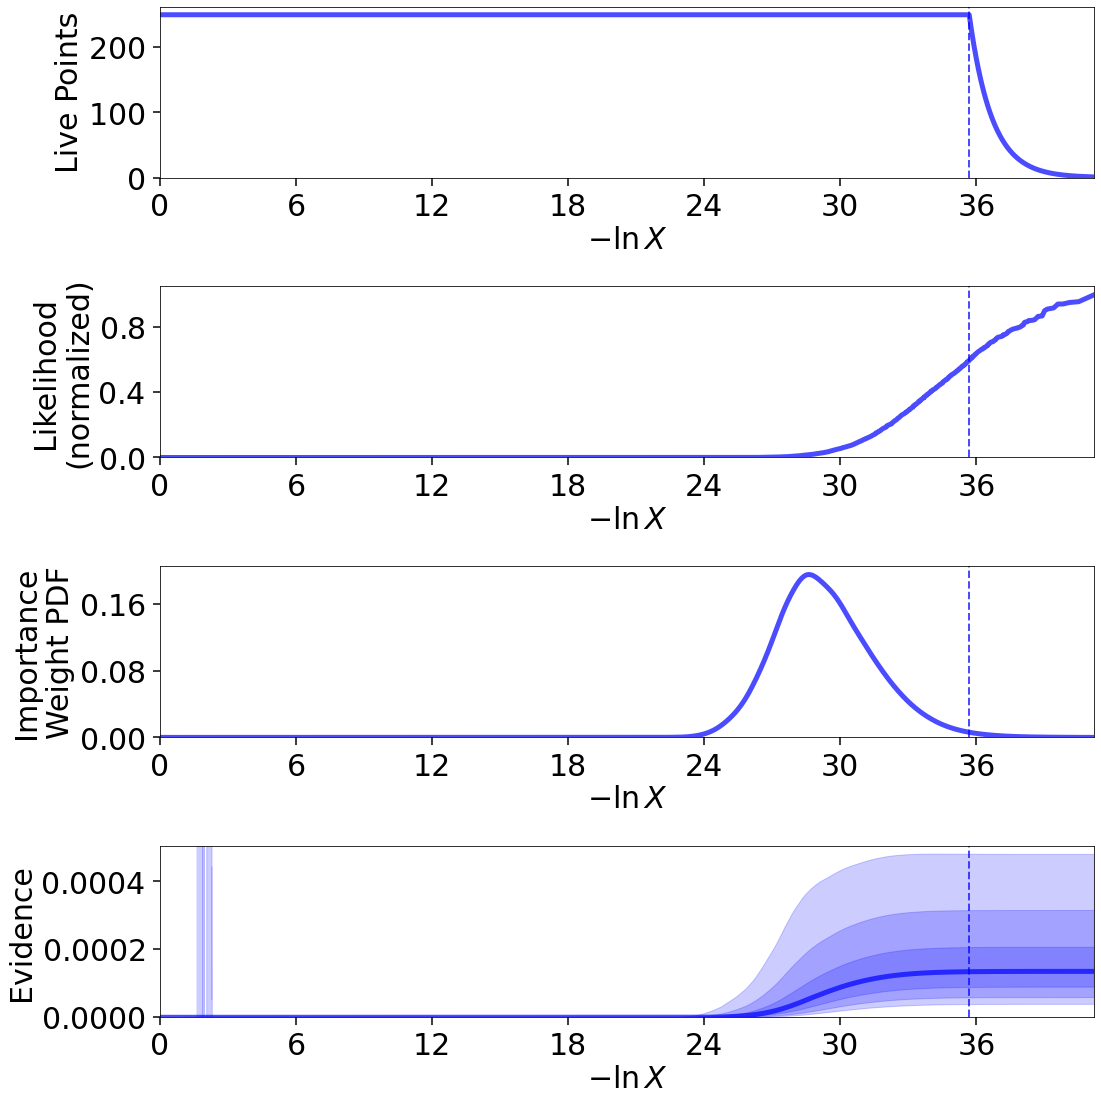

In [14]:
from dynesty import plotting as dyplot

dyplot.runplot(res)
plt.tight_layout()

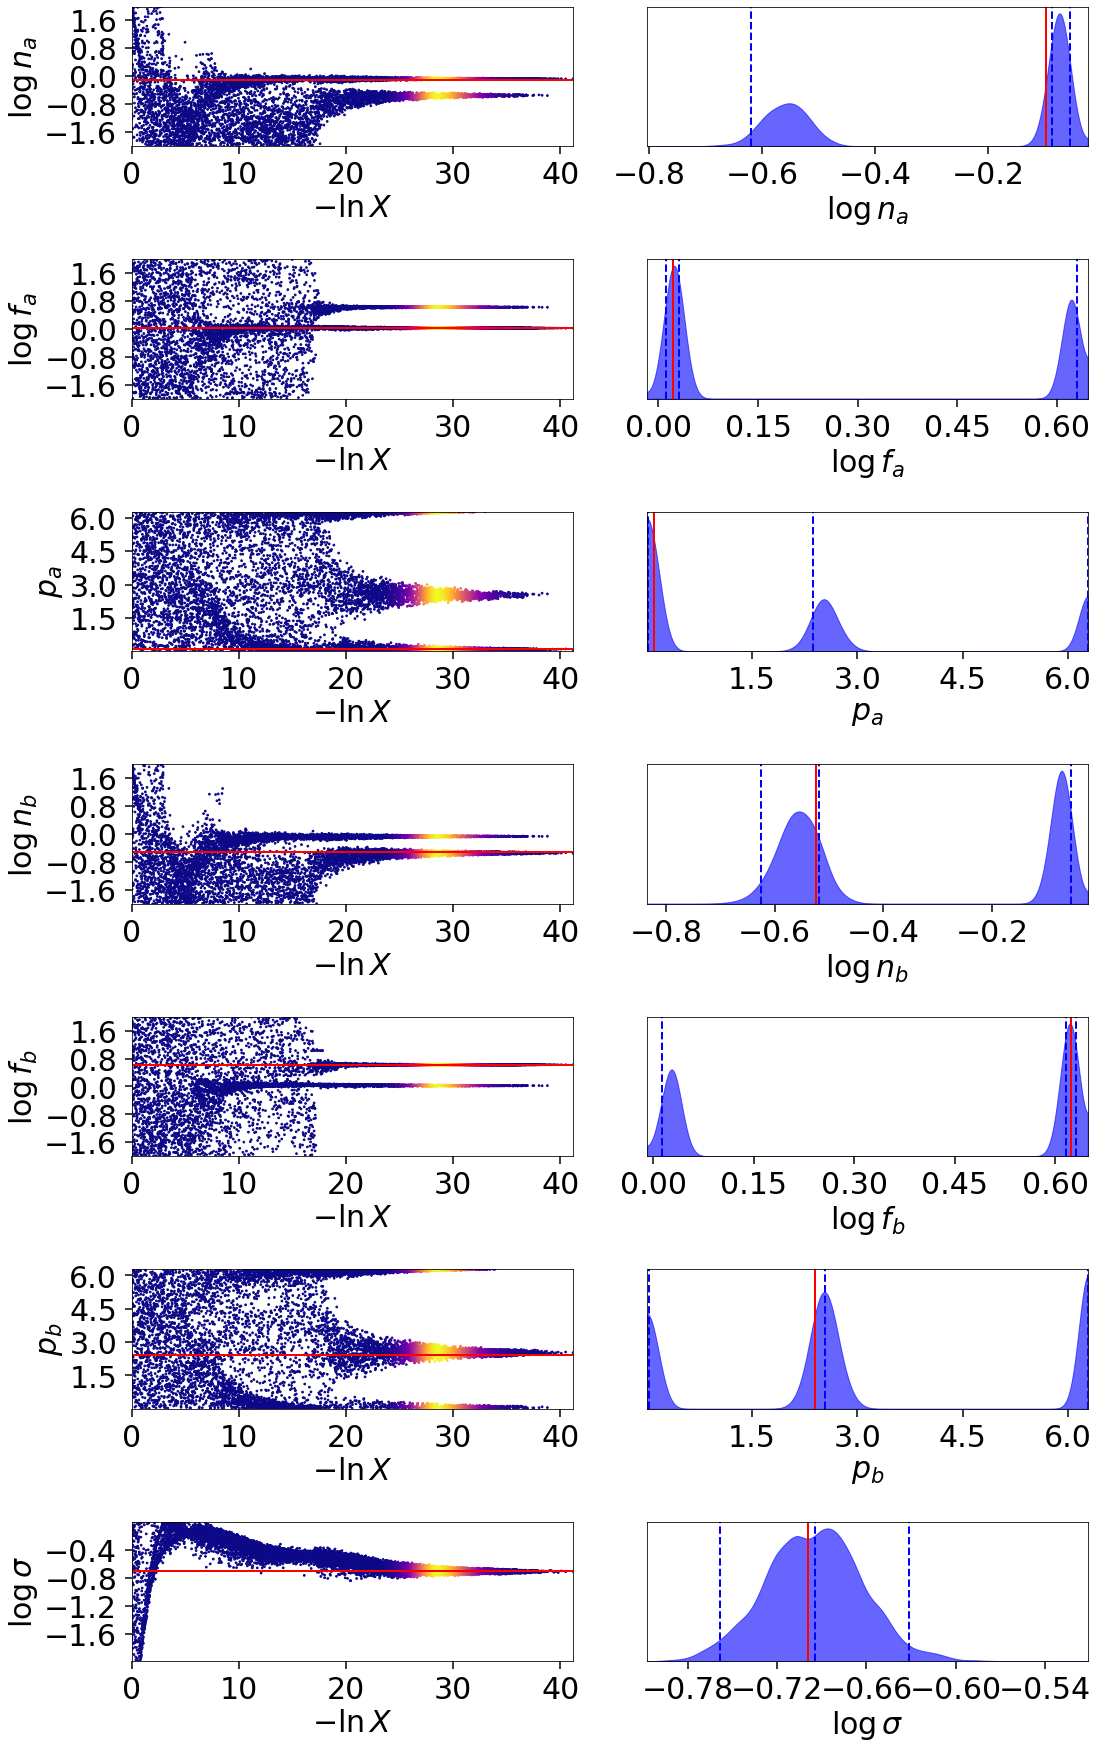

In [15]:
labels = [r'$\log n_a$', r'$\log f_a$', r'$p_a$', 
          r'$\log n_b$', r'$\log f_b$', r'$p_b$', 
          r'$\log \sigma$']
truths = [np.log10(na), np.log10(fa), pa,
          np.log10(nb), np.log10(fb), pb,
          np.log10(sigma)]
fig, axes = dyplot.traceplot(res, labels=labels, truths=truths,
                             fig=plt.subplots(7, 2, figsize=(16, 25)))
fig.tight_layout()

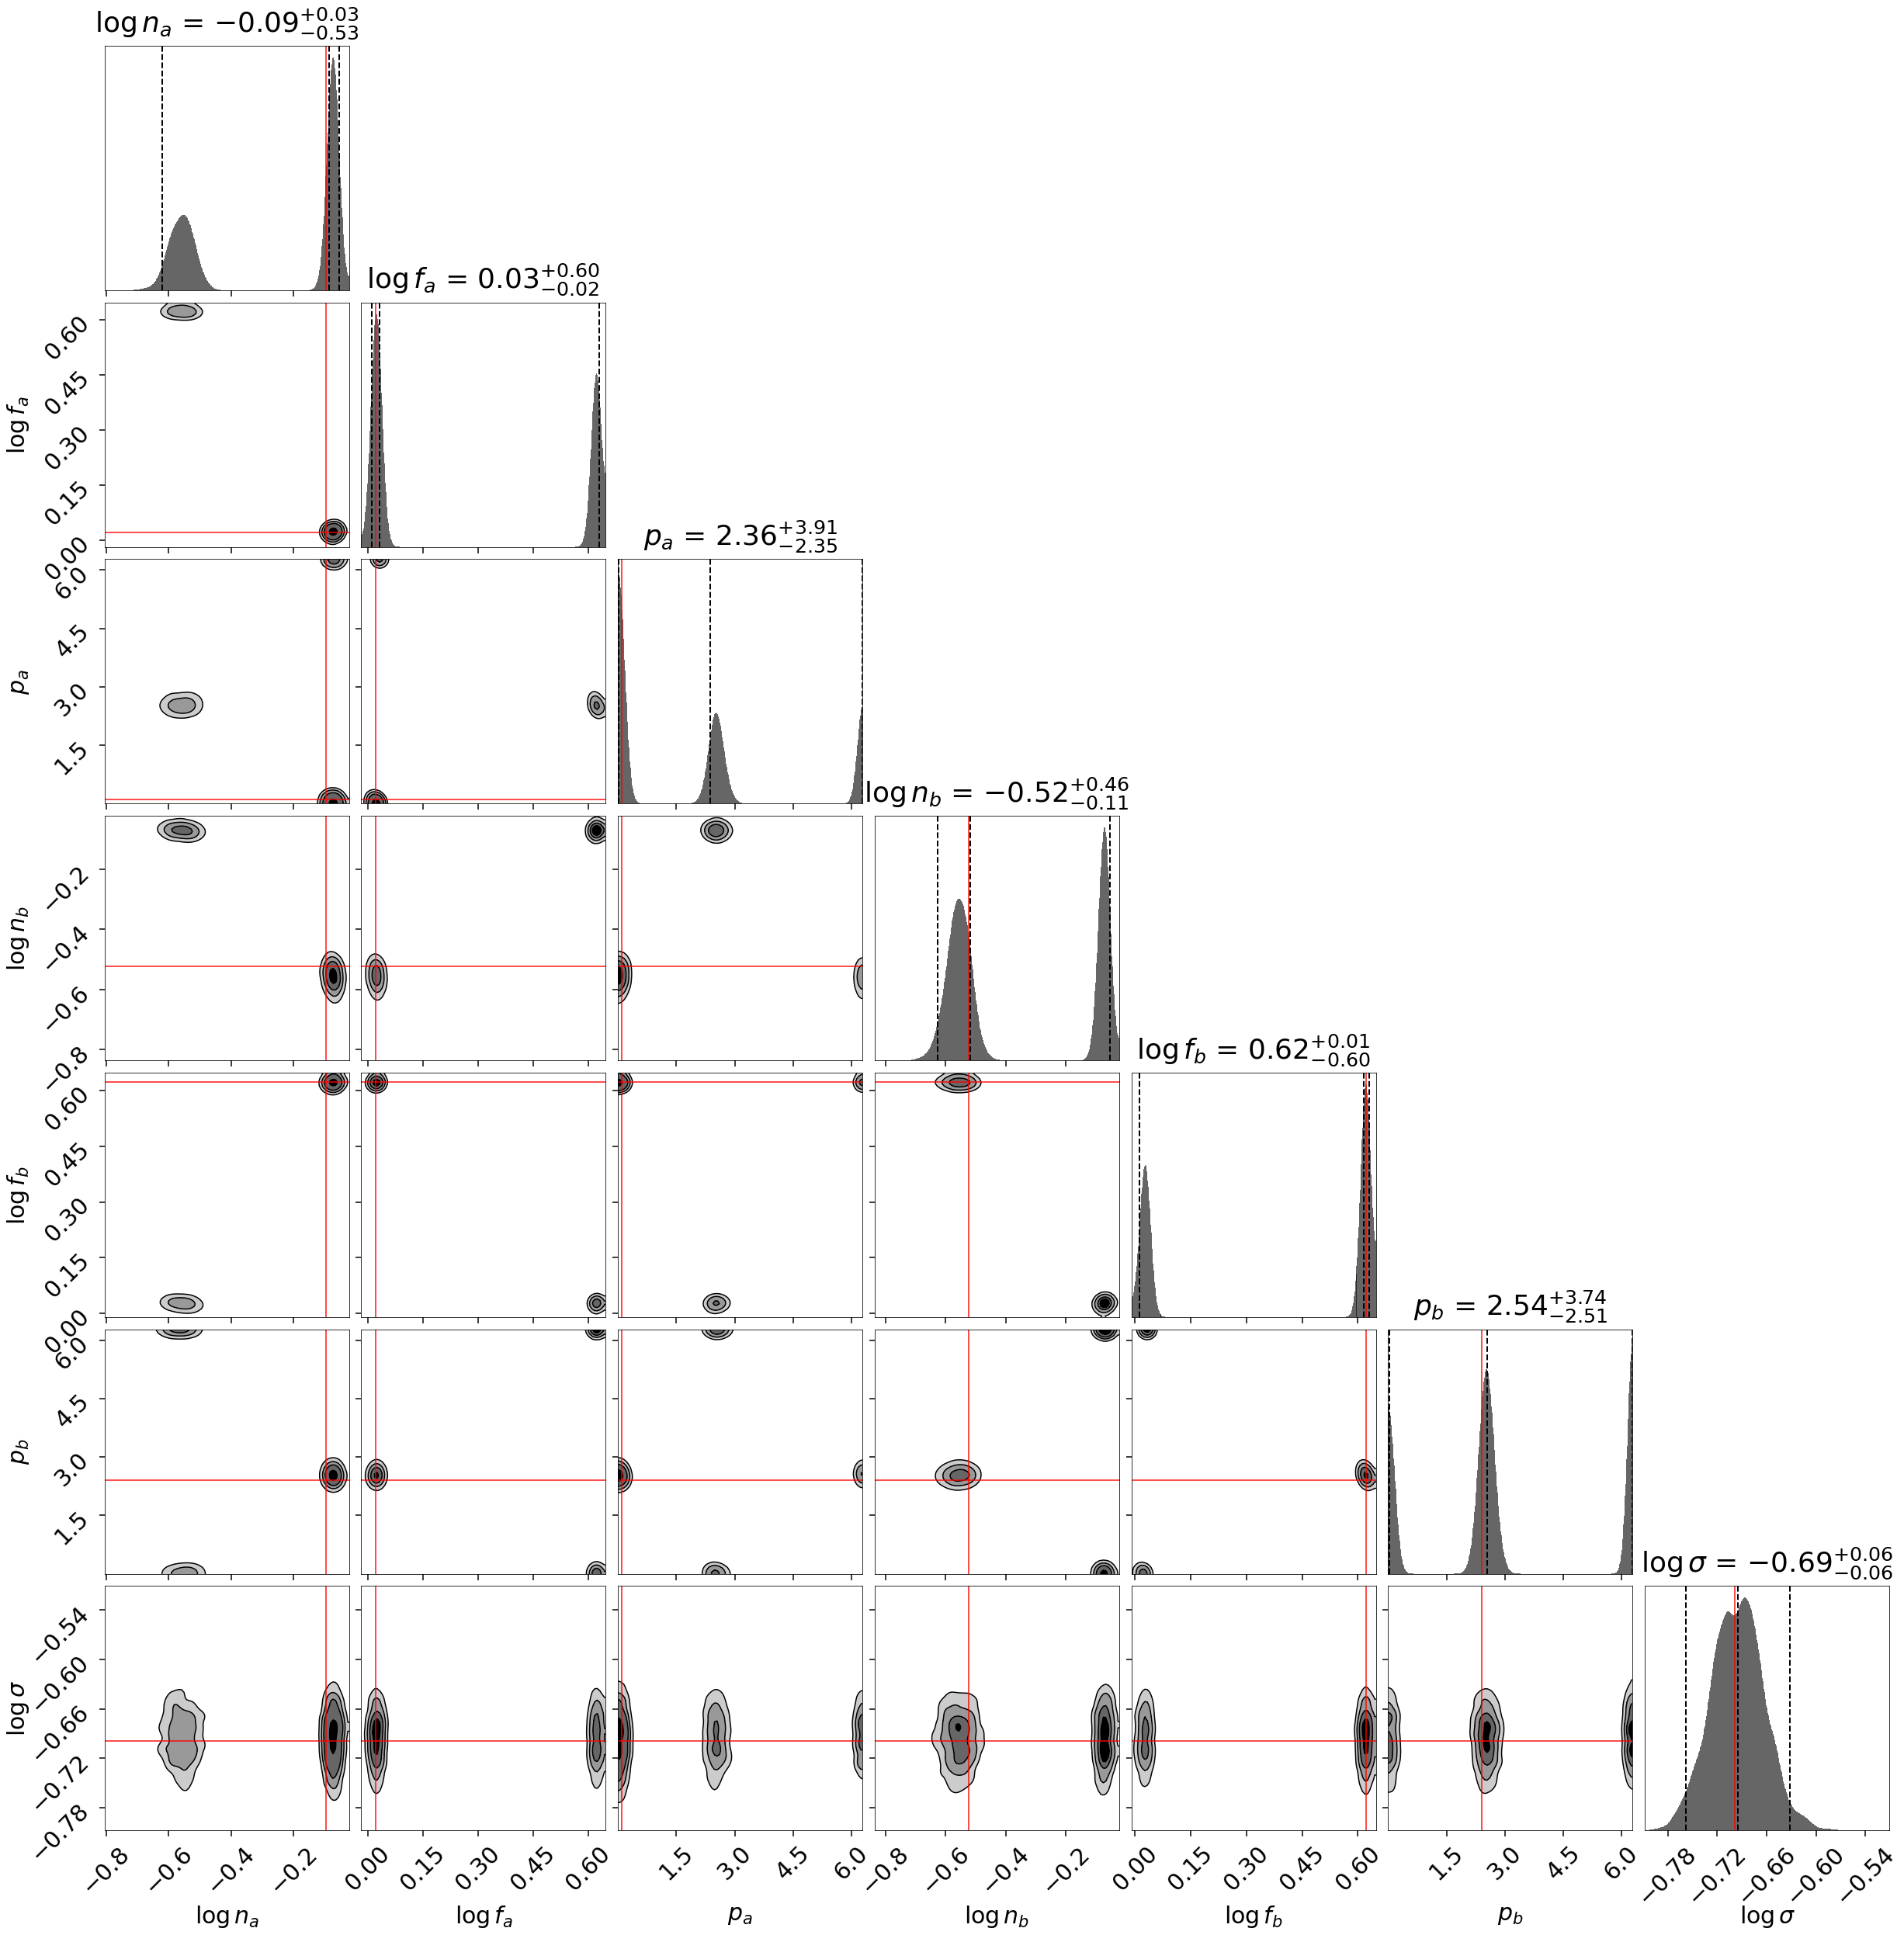

In [16]:
fig, axes = dyplot.cornerplot(res, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(7, 7, figsize=(35, 35)))